# 자연어 처리

In [5]:
import tensorflow as tf
import numpy as np

sentence = "hihello"

voca = set(sentence)
char2idx = {c:i for i, c in enumerate(voca)}
idx2char = {i:c for i, c in enumerate(voca)}
print(f'sentence: {sentence}')
print(f'char2idx:{char2idx}, idx2char:{idx2char}')

x = sentence[:-1]
y = sentence[1:]
print(f'x:{x}, y:{y}')

n_class= len(voca)
n_time_steps = len(x)
hidden_size = n_class

''' 문자열을 정수로 변경 '''
x_idx = [char2idx[c] for c in x]
y_idx = [char2idx[c] for c in y]
print(f'x_idx:{x_idx}, y_idx:{y_idx}')

''' 원핫 인코딩 '''
x_enc = tf.keras.utils.to_categorical(x_idx, num_classes=n_class)
x_enc = np.expand_dims(x_enc, axis=0)
y_enc = tf.keras.utils.to_categorical(y_idx, num_classes=n_class)
y_enc = np.expand_dims(y_enc, axis=0)
print("x_end : ", x_enc, x_enc.shape)
print("y_enc : ", y_enc, y_enc.shape)

sentence: hihello
char2idx:{'l': 0, 'e': 1, 'i': 2, 'h': 3, 'o': 4}, idx2char:{0: 'l', 1: 'e', 2: 'i', 3: 'h', 4: 'o'}
x:hihell, y:ihello
x_idx:[3, 2, 3, 1, 0, 0], y_idx:[2, 3, 1, 0, 0, 4]
x_end :  [[[0. 0. 0. 1. 0.]
  [0. 0. 1. 0. 0.]
  [0. 0. 0. 1. 0.]
  [0. 1. 0. 0. 0.]
  [1. 0. 0. 0. 0.]
  [1. 0. 0. 0. 0.]]] (1, 6, 5)
y_enc :  [[[0. 0. 1. 0. 0.]
  [0. 0. 0. 1. 0.]
  [0. 1. 0. 0. 0.]
  [1. 0. 0. 0. 0.]
  [1. 0. 0. 0. 0.]
  [0. 0. 0. 0. 1.]]] (1, 6, 5)


In [7]:
''' LSTM을 이용한 모델 학습 '''
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(hidden_size, input_shape=(n_time_steps, n_class), return_sequences= True))
model.add(tf.keras.layers.Dense(hidden_size))
model.add(tf.keras.layers.Activation('softmax'))
model.summary()

model.compile(optimizer ='adam', loss='sparse_categorical_crossentropy')

n_epochs=1000
hist = model.fit(x_enc, np.reshape(y_idx, (1,6,1)), epochs=n_epochs, verbose=0)

pred = model.predict(x_enc)
print(pred, np.squeeze(np.argmax(pred, axis=2)))
print([idx2char[i] for i in np.squeeze(np.argmax(pred, axis=2))])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 6, 5)              220       
                                                                 
 dense (Dense)               (None, 6, 5)              30        
                                                                 
 activation (Activation)     (None, 6, 5)              0         
                                                                 
Total params: 250
Trainable params: 250
Non-trainable params: 0
_________________________________________________________________
[[[3.46875861e-02 4.69757691e-02 8.08113277e-01 8.86284038e-02
   2.15949267e-02]
  [1.53215686e-02 8.77117142e-02 7.02990741e-02 8.19050491e-01
   7.61712436e-03]
  [3.30859497e-02 8.32960844e-01 4.11692485e-02 9.18781981e-02
   9.05672787e-04]
  [9.23814893e-01 4.89191152e-02 4.73511079e-03 8.29215720e-03
   1.423865

# Token Embedding
- One hot encoding의 단점 보완
- 밀집 벡터
- 방법론

## 영문 분류
- 긍정/부정 어휘 분류

In [16]:
# 긍정 부정 어휘 분류

import tensorflow as tf

corpus = ['very good nice quality',
         'stop lies',
         'ugly terrible',
         'excellent work',
         'adorable lovely',
         'bad',
         'grate nice']
y_tr = [1,0,0,1,1,0,1]

t = tf.keras.preprocessing.text.Tokenizer()
t.fit_on_texts(corpus)
vocab_size = len(t.word_index)+1
print('t.word_index :',t.word_index)
print(f'vocab_size : {vocab_size}')

X_encoded = t.texts_to_sequences(corpus)
print(f'integer encoded: {X_encoded}')

max_len = max(len(l) for l in X_encoded)
print(f'max_len: {max_len}')

t.word_index : {'nice': 1, 'very': 2, 'good': 3, 'quality': 4, 'stop': 5, 'lies': 6, 'ugly': 7, 'terrible': 8, 'excellent': 9, 'work': 10, 'adorable': 11, 'lovely': 12, 'bad': 13, 'grate': 14}
vocab_size : 15
integer encoded: [[2, 3, 1, 4], [5, 6], [7, 8], [9, 10], [11, 12], [13], [14, 1]]
max_len: 4


In [18]:
''' 빈값을 채워 넣는것 => padding '''
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_encoded, maxlen=max_len, padding='post')
y_tr = np.array(y_tr)

embd = tf.keras.layers.Embedding(vocab_size, 2, input_length=max_len)
print(f'embedding init : {embd(X_train)[:3]}')

model = tf.keras.Sequential()
model.add(embd)
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(1,activation='sigmoid'))
model.summary()

model.compile(optimizer = 'adam', loss='binary_crossentropy', metrics=['acc'])
model.fit(X_train, y_tr, epochs=500, verbose=0)

print(f'embedding last : {embd(X_train)[:3]}')

embedding init : [[[ 0.02976885 -0.02677418]
  [ 0.0018677   0.01708687]
  [-0.01192241  0.03716968]
  [ 0.00165765  0.02346356]]

 [[-0.02216829 -0.02273486]
  [ 0.01486084  0.04852592]
  [ 0.02038335  0.0223459 ]
  [ 0.02038335  0.0223459 ]]

 [[-0.02332535  0.00857754]
  [-0.03201717 -0.00971905]
  [ 0.02038335  0.0223459 ]
  [ 0.02038335  0.0223459 ]]]
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 4, 2)              30        
                                                                 
 flatten (Flatten)           (None, 8)                 0         
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 39
Trainable params: 39
Non-trainable params: 0
_____________________________

[[-0.20679438 -0.57748985]
 [ 0.40549308  0.40750372]
 [-0.32423067  0.48227698]
 [ 0.3743294   0.5487778 ]
 [ 0.36318108  0.3564992 ]
 [ 0.41098294 -0.6082907 ]
 [-0.43790978 -0.5578862 ]
 [ 0.40573618 -0.57307684]
 [-0.48065835 -0.61234057]
 [-0.47141197  0.6373071 ]
 [ 0.48496047  0.5728398 ]
 [-0.45924726  0.6431271 ]
 [ 0.4428635   0.5921874 ]
 [ 0.422699   -0.58599305]
 [-0.472609    0.6280977 ]]


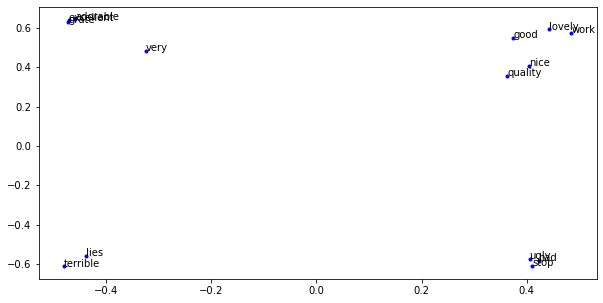

In [24]:
''' 가중치를 이용한 글자 시각화 '''
import matplotlib.pyplot as plt

embd_matrix = embd.get_weights()[0]
print(embd_matrix)
plt.figure(figsize=(10,5))
for idx, (x1,x2) in enumerate(embd_matrix):
    if idx==0: continue
    plt.plot(x1,x2,'b.')
    plt.annotate(t.index_word[idx],(x1,x2))